# Part 4: Projects and Automated ML Pipeline

This part of the MLRun getting-started tutorial walks you through the steps for working with projects, source control (git), and automating the ML pipeline.

MLRun Project is a container for all your work on a particular activity: all the associated code, functions, 
jobs/workflows and artifacts. Projects can be mapped to `git` repositories to enable versioning, collaboration, and CI/CD.

You can create project definitions using the SDK or a yaml file and store those in MLRun DB, file, or archive.
Once the project is loaded you can run jobs/workflows which refer to any project element by name, allowing separation between configuration and code. See [Create and load projects](../projects/create-load-import-project.md) for details.

Projects contain `workflows` that execute the registered functions in a sequence/graph (DAG), and which can reference project parameters, secrets and artifacts by name. MLRun currently supports two workflow engines, `local` (for simple tasks) and [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/pipelines-quickstart/) (for more complex/advanced tasks). MLRun also supports a real-time workflow engine (see [MLRun serving graphs](../serving/serving-graph.md)). 

> **Note**: The Iguazio MLOps Platform has a default (pre-deployed) shared Kubeflow Pipelines service (`pipelines`).

An ML Engineer can gather the different functions created by the Data Engineer and Data Scientist and create this automated pipeline.

The tutorial consists of the following steps:

1. [Setting up Your Project](#gs-tutorial-4-step-setting-up-project)
2. [Updating Project and Function Definitions](#gs-tutorial-4-step-import-functions)
3. [Defining and Saving a Pipeline Workflow](#gs-tutorial-4-step-pipeline-workflow-define-n-save)
4. [Registering the Workflow](#gs-tutorial-4-step-register-workflow)
5. [Running A Pipeline](#gs-tutorial-4-step-run-pipeline)
6. [Viewing the Pipeline on the Dashboard (UI)](#gs-tutorial-4-step-ui-pipeline-view)
7. [Invoking the Model](#gs-tutorial-4-step-invoke-model)

By the end of this tutorial you'll learn how to:

- Create an operational pipeline using previously defined functions.
- Run the pipeline and track the pipeline results.

<a id="gs-tutorial-4-prerequisites"></a>

## Prerequisites

The following steps are a continuation of the previous parts of this getting-started tutorial and rely on the generated outputs.
Therefore, make sure to first run parts [1](01-mlrun-basics.ipynb)&mdash;[3](03-model-serving.ipynb) of the tutorial.

<a id="gs-tutorial-4-step-setting-up-project"></a>

## Step 1: Setting Up Your Project

To run a pipeline, you first need to create a Python project object and import the required functions for its execution.

Create a project by using one of:

- the `new_project` MLRun method
- the `get_or_create_project`method: loads a project from the MLRun DB or the archive/context if it exists, or creates a new project if it doesn't exist.

Both methods have the following parameters:

- **`name`** (required) &mdash; the project name.
- **`context`** &mdash; the path to a local project directory (the project's context directory).
  The project directory contains a project-configuration file (default: **project.yaml**) that defines the project, and additional generated Python code.
  The project file is created when you save your project (using the `save` MLRun project method or when saving your first function within the project).
- **`init_git`** &mdash; set to `True` to perform Git initialization of the project directory (`context`) in case its not initialized.
  > **Note:** It's customary to store project code and definitions in a Git repository.

The following code gets or creates a user project named "getting-started-&lt;username&gt;".

> **Note:** Platform projects are currently shared among all users of the parent tenant, to facilitate collaboration. Therefore:
>
> - Set `user_project` to `True` if you want to create a project unique to your user.
>   You can easily change the default project name for this tutorial by changing the definition of the `project_name_base` variable in the following code.
> - Don't include in your project proprietary information that you don't want to expose to other users.
>   Note that while projects are a useful tool, you can easily develop and run code in the platform without using projects.

In [1]:
import mlrun

# Set the base project name
project_name_base = 'getting-started'

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name_base, context="./", user_project=True, init_git=True)

print(f'Full project name: {project.metadata.name}')

> 2022-02-08 22:48:12,960 [info] loaded project getting-started from MLRun DB
Full project name: getting-started-admin


<a id="gs-tutorial-4-step-import-functions"></a>

## Step 2: Updating Project and Function Definitions

You must save the definitions for the functions used in the project so that you can automatically convert code to functions, import external functions when you load new versions of MLRun code, or run automated CI/CD workflows. In addition, you might want to set other project attributes such as global parameters, secrets, and data.

The code can be stored in Python files, notebooks, external repositories, packaged containers, etc. Use the `project.set_function()` method to register the code in the project. The definitions are saved to the project object as well as in a YAML file in the root of the project.
Functions can also be imported from MLRun marketplace (using the `hub://` schema).

This tutorial uses the functions:
- `prep-data` &mdash; the first function, which ingests the Iris data set (in Notebook 01)
- `describe` &mdash; generates statistics on the data set (from the marketplace)
- `train-iris` &mdash; the model-training function (in Notebook 02)
- `test-classifier` &mdash; the model-testing function (from the marketplace)
- `mlrun-model` &mdash; the model-serving function (in Notebook 03)

> Note: `set_function` uses the `code_to_function` and `import_function` methods under the hood (used in the previous notebooks), but in addition it saves the function configurations in the project spec for use in automated workflows and CI/CD. 

Add the function definitions to the project along with parameters and data artifacts, and save the project.

<a id="gs-tutorial-4-view-project-functions"></a>

In [2]:
project.set_function('01-mlrun-basics.ipynb', 'prep-data', kind='job', image='mlrun/mlrun')
project.set_function('02-model-training.ipynb', 'train', kind='job', image='mlrun/mlrun', handler='train_iris')

# set project level parameters and save
project.spec.params = {'label_column': 'label'}
project.save()

<br>When you save the project it stores the project definitions in the `project.yaml`. This means that you can load the project from the source control (GIT) and run it with a single command or API call.

The project YAML for this project can be printed using:

In [3]:
print(project.to_yaml())

kind: project
metadata:
  name: getting-started-admin
  created: '2022-02-06T17:00:53.057000+00:00'
spec:
  params:
    label_column: label
  functions:
  - url: 01-mlrun-basics.ipynb
    name: prep-data
    kind: job
    image: mlrun/mlrun
  - url: 02-model-training.ipynb
    name: train
    kind: job
    image: mlrun/mlrun
    handler: train_iris
  workflows:
  - name: main
    path: workflow.py
    engine: null
  artifacts: []
  source: ''
  subpath: ''
  origin_url: ''
  desired_state: online
  owner: admin
  disable_auto_mount: false
status:
  state: online



### Saving and Loading Projects from GIT

After you save the project and its elements (functions, workflows, artifacts, etc.) you can commit all the changes to a GIT repository. Use the standard GIT tools or use the MLRun `project` methods such as `pull`, `push`, `remote`, which call the Git API for you.

Projects can then be loaded from GIT using the MLRun `load_project` method, for example: 

    project = mlrun.load_project("./myproj", "git://github.com/mlrun/project-demo.git", name=project_name)
    
or using MLRun CLI:

    mlrun project -n myproj -u "git://github.com/mlrun/project-demo.git" ./myproj
    
Read [Create and load projects](../projects/create-load-import-project.md) for more details.

<a id="gs-tutorial-4-kubeflow-pipelines"></a>

### Using Kubeflow Pipelines

You're now ready to create a full ML pipeline.
This is done by using [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/overview/pipelines-overview/) &mdash;
an open-source framework for building and deploying portable, scalable machine-learning workflows based on Docker containers.
MLRun leverages this framework to take your existing code and deploy it as steps in the pipeline.

> **Note:** When using the Iguazio MLOps Platform, Kubeflow Pipelines is available as a default (pre-deployed) shared platform service.

<a id="gs-tutorial-4-step-pipeline-workflow-define-n-save"></a>

## Step 3: Defining and Saving a Pipeline Workflow

A pipeline is created by running an MLRun **"workflow"**.
The following code defines a workflow and writes it to a file in your local directory, with the file name **workflow.py**.
The workflow describes a directed acyclic graph (DAG) for execution using Kubeflow Pipelines, and depicts the connections between the functions and the data as part of an end-to-end pipeline.
The workflow file has two parts: initialization of the function objects, and definition of a pipeline DSL (domain-specific language) for connecting the function inputs and outputs.
Examine the code to see how function objects are initialized and used (by name) within the workflow.

The defined pipeline includes the following steps:

- Ingest the Iris flower data set (`ingest`).
- Train and the model (`train`).
- Test the model with its test data set.
- Deploy the model as a real-time serverless function (`deploy`).

> **Note**: A pipeline can also include continuous build integration and deployment (CI/CD) steps, such as building container images and deploying models.

In [4]:
%%writefile './workflow.py'

from kfp import dsl
import mlrun

DATASET = 'cleaned_data'

# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="Getting-started-tutorial",
    description="Demonstrate some of the main capabilities of MLRun"
)
def kfpipeline(source_url, model_name="iris"):
    project = mlrun.get_current_project()

    # Ingest the data set
    ingest = mlrun.run_function(
        'prep-data',
        handler='prep_data',
        inputs={'source_url': source_url},
        params={'label_column': project.get_param("label_column")},
        outputs=[DATASET])
    
    # Train a model   
    train = mlrun.run_function(
        "train",
        params={"label_column": project.get_param("label_column")},
        inputs={"dataset": ingest.outputs[DATASET]},
        outputs=['model', 'test_set'])
    
    # Test and visualize the model
    test = mlrun.run_function(
        "hub://test_classifier",
        params={"label_column": project.get_param("label_column")},
        inputs={"models_path": train.outputs['model'],
                "test_set": train.outputs['test_set']})
    
    # Deploy the model as a serverless function
    serving = mlrun.import_function("hub://v2_model_server", new_name="serving")
    deploy = mlrun.deploy_function(serving,
                                   models=[{"key":model_name, "model_path": train.outputs['model']}])

Overwriting ./workflow.py


<a id="gs-tutorial-4-step-register-workflow"></a>

## Step 4: Registering the Workflow

Use the `set_workflow` MLRun project method to register your workflow with MLRun.
The following code sets the `name` parameter to the selected workflow name ("main") and the `code` parameter to the name of the workflow file that is found in your project directory (**workflow.py**).

In [5]:
# Register the workflow file as "main"
project.set_workflow('main', 'workflow.py')

<a id="gs-tutorial-4-step-run-pipeline"></a>

## Step 5: Running A Pipeline

First run the following code to save your project:

In [6]:
project.save()

Use the `run` MLRun project method to execute your workflow pipeline with Kubeflow Pipelines.
The tutorial code sets the following method parameters; (for the full parameters list, see the [MLRun documentation](../api/mlrun.run.html#mlrun.run.run_pipeline) or embedded help):

- **`name`** &mdash; the workflow name (in this case, "main" &mdash; see the previous step).
- **`arguments`** &mdash; A dictionary of Kubeflow Pipelines arguments (parameters).
  The tutorial code sets this parameter to an empty arguments list (`{}`), but you can edit the code to add arguments.
- **`artifact_path`** &mdash; a path or URL that identifies a location for storing the workflow artifacts.
  You can use `{{workflow.uid}}` in the path to signify the ID of the current workflow run iteration.
  The tutorial code sets the artifacts path to a **&lt;worker ID&gt;** directory (`{{workflow.uid}}`) in a **pipeline** directory under the projects container (**/v3io/projects/getting-started-tutorial-project name/pipeline/&lt;worker ID&gt;**).
- **`dirty`** &mdash; set to `True` to allow running the workflow also when the project's Git repository is dirty (i.e., contains uncommitted changes).
  (When the notebook that contains the execution code is in the same Git directory as the executed workflow, the directory is always dirty during the execution.)
- **`watch`** &mdash; set to `True` to wait for the pipeline to complete and output the execution graph as it updates.

The `run` method returns the ID of the executed workflow, which the code stores in a `run_id` variable.
You can use this ID to track the progress or your workflow, as demonstrated in the following sections.

> **Note**: You can also run the workflow from a command-line shell by using the `mlrun` CLI.
> The following CLI command defines a similar execution logic as that of the `run` call in the tutorial:
> ```
> mlrun project /User/getting-started-tutorial/conf -r main -p "$V3IO_HOME_URL/getting-started-tutorial/pipeline/{{workflow.uid}}/"
> ```

In [7]:
source_url = mlrun.get_sample_path("data/iris/iris.data.raw.csv")
model_name="iris"

# when not using a managed cluster run with "local" engine (assume no Kubeflow)
engine = "kfp" if mlrun.mlconf.remote_host else "local"  

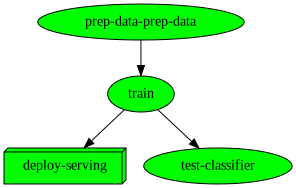

uid,start,state,name,parameters,results
...473a6930,Feb 08 22:50:08,completed,test-classifier,label_column=label,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0
...4fa4647e,Feb 08 22:49:55,completed,train,label_column=label,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0
...b60d7edf,Feb 08 22:49:43,completed,prep-data-prep_data,label_column=label,num_rows=150


In [8]:
model_name="iris"
run_id = project.run(
    'main',
    arguments={'source_url' : source_url, "model_name": model_name}, 
    #dirty=True,
    engine=engine,
    watch=True)

<a id="gs-tutorial-4-step-ui-pipeline-view"></a>

## Step 6: Viewing the Pipeline on the Dashboard (UI)

In the **Projects > Jobs and Workflows > Monitor Workflows** tab, press the workflow name to view a graph of the workflow. Press any step to open another pane with full details of the step: either the job's overview, inputs, artifacts, etc.; or the deploy / build function's overview, code, and log. 


After the pipelines execution completes, you should be able to view the pipeline and see its functions: 

- `prep-data`
- `train`
- `test`
- `deploy-serving`

The graph is refreshed while the pipeline is running.

<img src="../_static/images/tutorial/job_pipeline.png" alt="pipeline" width="700"/>

<a id="gs-tutorial-4-step-invoke-model"></a>

## Step 7: Invoking the Model

Now that your model is deployed using the pipeline, you can invoke it as usual:

In [48]:
serving_func = project.func('serving')  # get the latest serving function

my_data = {'inputs': [[5.1, 3.5, 1.4, 0.2],[7.7, 3.8, 6.7, 2.2]]}
serving_func.invoke(f'/v2/models/{model_name}/predict', my_data)

> 2022-02-08 22:33:07,930 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-getting-started-admin-serving.default-tenant.svc.cluster.local:8080/v2/models/iris/infer'}


{'id': '1a938c32-0be5-4f6b-a468-0cfc0cb60a6a',
 'model_name': 'iris',
 'outputs': [0, 2]}

You can also make an HTTP call directly:

In [50]:
import requests
import json
predict_url = f'http://{serving_func.status.address}/v2/models/{model_name}/predict'
resp = requests.put(predict_url, json=json.dumps(my_data))
print(resp.json())

{'id': '296c0de3-0d3d-4286-84ef-ed297d15727f', 'model_name': 'iris', 'outputs': [0, 2]}


<a id="gs-tutorial-4-done"></a>

## Done!

Congratulations! You've completed the getting started tutorial.

You might also want to explore the following demos:

- For an example of distributed training of an image-classification pipeline using TensorFlow (versions 1 or 2), Keras, and Horovod, see the [**image-classification with distributed training demo**](https://github.com/mlrun/demos/tree/release/v0.6.x-latest/image-classification-with-distributed-training).
- To learn more about deploying live endpoints and concept drift, see the [**network-operations (NetOps) demo**](https://github.com/mlrun/demos/tree/release/v0.6.x-latest/network-operations).
- To learn how to deploy your model with streaming information, see the [**model-deployment pipeline demo**](https://github.com/mlrun/demos/tree/release/v0.6.x-latest/model-deployment-pipeline).

For additional information and guidelines, see the MLRun [**How-To Guides and Demos**](../howto/index.md).